# MS002 Preprocess
01/10/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/afink_lfp_pipeline/LFPAnalysis/')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS002'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [5]:
edf_files = glob(f'{neural_dir}/{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS002_SWB.edf, 276 x 2219008 (2167.0 s), ~4.56 GB, data loaded>

In [7]:
mne_data.ch_names

['LlOiF1',
 'LlOiF2',
 'LlOiF3',
 'LlOiF4',
 'LlOiF5',
 'LlOiF6',
 'LlOiF7',
 'LlOiF8',
 'LlOiF9',
 'LlOiF10',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LmOlF13',
 'LmOlF14',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'RmOlF10',
 'RmOlF11',
 'RmOlF12',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13',
 'RaCaS14',
 'C63',
 'C64',
 'LalmS1',
 'LalmS2',
 'LalmS3',
 'LalmS4',
 'LalmS5',
 'LalmS6',
 'LalmS7',
 'LalmS8',
 'LalmS9',
 'LalmS10',
 'LalmS11',
 'LalmS12',
 'LalmS13',
 'LalmS14',
 'RalmS1',
 'RalmS2',
 'RalmS3',
 'RalmS4',
 'RalmS5',
 'RalmS6',
 'RalmS7',
 'RalmS8',
 'RalmS9',
 'RalmS10',
 'RalmS11',
 'R

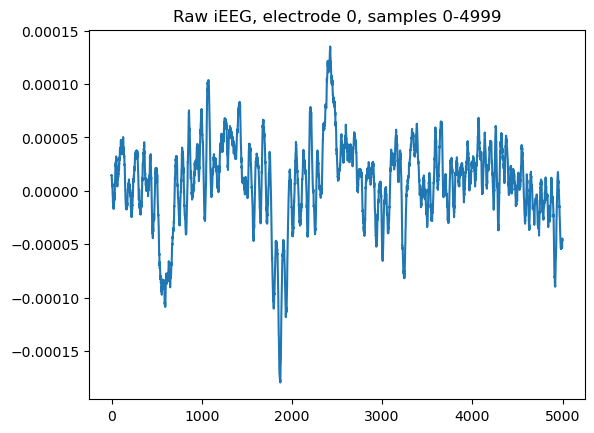

In [8]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   16.8s finished


<RawEDF | MS002_SWB.edf, 276 x 1083500 (2167.0 s), ~2.23 GB, data loaded>

### Photodiode
- examine photodiode 
- save out before resampling/notch filtering *unless nlx - then you have to resample first 

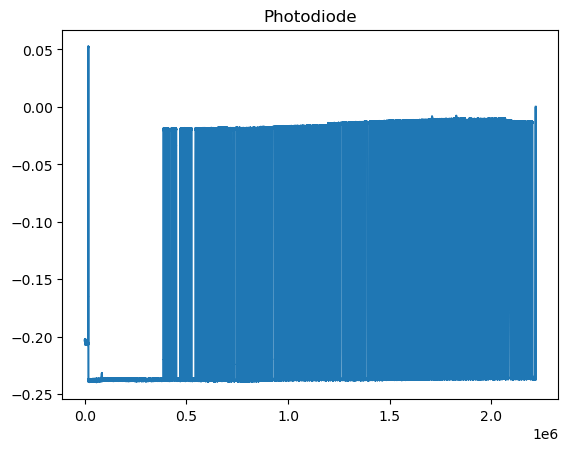

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [13]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

In [14]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

### Notch filter line noise

In [15]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    5.9s finished


<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

In [18]:
#make channel names lowercase 
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

### Anatomical Localization

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -6.784557  49.555827   0.149337  -6.382462   
1    LaCaS10      A9l_L  -8.380923  61.155821  43.676991  -8.220073   
2    LaCaS11      A9l_L  -8.780014  62.355821  48.469026  -8.542609   
3    LaCaS12    Unknown  -8.780014  63.555820  53.261062  -8.436667   
4     LaCaS2    A32sg_L  -6.784557  50.755827   4.941372  -6.368174   
..       ...        ...        ...        ...        ...        ...   
153   RmOIF5  A12/47o_R  33.922762  42.355831  -8.636061  34.666463   
154   RmOIF6  A12/47l_R  37.913675  41.555831  -6.240044  38.716568   
155   RmOIF7  A12/47l_R  41.904589  40.755832  -3.844026  42.794042   
156   RmOIF8  A12/47l_R  46.294594  39.555832  -1.048672  47.308597   
157   RmOIF9     A45r_R  50.285508  38.755833   1.746682  51.450368   

         mni_y      mni_z       gm  \
0    37.158688  -3.130044     Gray   
1    48.757099  44.868611     Gray   
2    49.887710  50.203768  Unknown   
3    51.044299  55.539730  Unknown   
4    38.606223   2.270621     Gray   
..         ...        ...      ...   
153  28.882016 -13.444118    White   
154  28.139395 -11.063832     Gray   
155  27.279509  -8.584441     Gray   
156  25.926043  -5.816665     Gray   
157  25.170889  -3.096492     Gray   

                                                   NMM     Anat  \
0                   Left ACgG anterior cingulate gyrus  Unknown   
1                      Left SFG superior frontal gyrus  Unknown   
2                      Left SFG superior frontal gyrus  Unknown   
3                                              Unknown  Unknown   
4                   Left ACgG anterior cingulate gyrus  Unknown   
..                                                 ...      ...   
153                        Right Cerebral White Matter  Unknown   
154                        Right Cerebral White Matter  Unknown   
155  Right OrIFG orbital part of the inferior front...  Unknown   
156  Right OrIFG orbital part of the inferior front...  Unknown   
157  Right TrIFG triangular part of the inferior fr...  Area 45   

                   AnatMacro    BN246                             YBA_1  \
0                      L ACC     L CG            Left cingulate gyrus D   
1    L Superior Medial Gyrus    L SFG   Left superior frontal gyrus 2 C   
2    L Superior Medial Gyrus    L SFG   Left superior frontal gyrus 2 C   
3                    Unknown  Unknown                           Unknown   
4                      L ACC     L CG            Left cingulate gyrus E   
..                       ...      ...                               ...   
153      R IFG (p Orbitalis)    R OrG         Right frontal orbital 4 D   
154      R IFG (p Orbitalis)    R OrG         Right frontal orbital 4 D   
155      R IFG (p Orbitalis)    R OrG            Right pars orbitalis C   
156      R IFG (p Orbitalis)    R OrG  Right middle pars triangularis B   
157      R IFG (p Orbitalis)    R IFG  Right middle pars triangularis B   

    ManualExamination Notes  
0                 NaN   NaN  
1                 NaN   NaN  
2                 OOB   NaN  
3                 OOB   NaN  
4                 NaN   NaN  
..                ...   ...  
153                WM   NaN  
154               NaN   NaN  
155               NaN   NaN  
156               NaN   NaN  
157               NaN   NaN  

[158 rows x 16 columns]

In [22]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LaImS1',
 'LaImS10',
 'LaImS11',
 'LaImS12',
 'LaImS13',
 'LaImS14',
 'LaImS2',
 'LaImS3',
 'LaImS4',
 'LaImS5',
 'LaImS6',
 'LaImS7',
 'LaImS8',
 'LaImS9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LlOiF1',
 'LlOiF10',
 'LlOiF2',
 'LlOiF3',
 'LlOiF4',
 'LlOiF5',
 'LlOiF6',
 'LlOiF7',
 'LlOiF8',
 'LlOiF9',
 'LmOIF1',
 'LmOIF10',
 'LmOIF11',
 'LmOIF12',
 'LmOIF13',
 'LmOIF14',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LpIpS1',
 'LpIpS10',
 'LpIpS11',
 'LpIpS12',
 'LpIpS13',
 'LpIpS14',
 'LpIpS2',
 'LpIpS3',
 'LpIpS4',
 'LpIpS5',
 'LpIpS6',
 'LpIpS7',
 'LpIpS8',
 'LpIpS9',
 'LsiF1',
 'LsiF2',
 'LsiF3',
 

In [20]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmolf1', 'lmolf2', 'lmolf3', 'lmolf4', 'lmolf5', 'lmolf6', 'lmolf7', 'lmolf8', 'lmolf9', 'lmolf10', 'lmolf11', 'lmolf12', 'lmolf13', 'lmolf14', 'rmolf1', 'rmolf2', 'rmolf3', 'rmolf4', 'rmolf5', 'rmolf6', 'rmolf7', 'rmolf8', 'rmolf9', 'rmolf10', 'rmolf11', 'rmolf12', 'c63', 'c64', 'lalms1', 'lalms2', 'lalms3', 'lalms4', 'lalms5', 'lalms6', 'lalms7', 'lalms8', 'lalms9', 'lalms10', 'lalms11', 'lalms12', 'lalms13', 'lalms14', 'ralms1', 'ralms2', 'ralms3', 'ralms4', 'ralms5', 'ralms6', 'ralms7', 'ralms8', 'ralms9', 'ralms10', 'ralms11', 'ralms12', 'ralms13', 'ralms14', 'lslif1', 'lslif2', 'lslif3', 'lslif4', 'lslif5', 'lslif6', 'lslif7', 'lslif8', 'lplps1', 'lplps2', 'lplps3', 'lplps4', 'lplps5', 'lplps6', 'lplps7', 'lplps8', 'lplps9', 'lplps10', 'lplps11', 'lplps12', 'lplps13', 'lplps14', 'laglt1', 'laglt2', 'laglt3', 'laglt4', 'laglt5', 'laglt6', 'laglt7', 'laglt8', 'laglt9', 'laglt10', 'c125', 'c126', 'c127', 'c128', 'raglt1', 'raglt2', 'raglt3', 'raglt4', 'raglt5', 'raglt6', 'raglt7',

In [23]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file
       name  lev_score
273  lloif7   0.833333
274  lmolf7   0.833333
We have too many possible matches for lmoif7! Select one manually from these candidates:lmolf7
       name  lev_score
273  lloif2   0.833333
274  lmolf2   0.833333
We have too many possible matches for lmoif2! Select one manually from these candidates:lmolf2
       name  lev_score
273  lloif1   0.833333
274  lmolf1   0.833333
We have too many possible matches for lmoif1! Select one manually from these candidates:lmolf1
       name  lev_score
273  lloif9   0.833333
274  lmolf9   0.833333
We have too many possible matches for lmoif9! Select one manually from these candidates:lmolf9
       name  lev_score
273  lloif3   0.833333
274  lmolf3   0.833333
We have too many possible matches for lmoif3! Select one manually from these candidates:lmolf3
       name  lev_score
273  lloif6   0.833333
274  lmolf6   0.833333
We have 

In [24]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [25]:
new_name_dict


{'lloif1': 'lloif1',
 'lloif2': 'lloif2',
 'lloif3': 'lloif3',
 'lloif4': 'lloif4',
 'lloif5': 'lloif5',
 'lloif6': 'lloif6',
 'lloif7': 'lloif7',
 'lloif8': 'lloif8',
 'lloif9': 'lloif9',
 'lloif10': 'lloif10',
 'lmolf1': 'lmoif1',
 'lmolf2': 'lmoif2',
 'lmolf3': 'lmoif3',
 'lmolf4': 'lmoif4',
 'lmolf5': 'lmoif5',
 'lmolf6': 'lmoif6',
 'lmolf7': 'lmoif7',
 'lmolf8': 'lmoif8',
 'lmolf9': 'lmoif9',
 'lmolf10': 'lmoif10',
 'lmolf11': 'lmoif11',
 'lmolf12': 'lmoif12',
 'lmolf13': 'lmoif13',
 'lmolf14': 'lmoif14',
 'rmolf1': 'rmoif1',
 'rmolf2': 'rmoif2',
 'rmolf3': 'rmoif3',
 'rmolf4': 'rmoif4',
 'rmolf5': 'rmoif5',
 'rmolf6': 'rmoif6',
 'rmolf7': 'rmoif7',
 'rmolf8': 'rmoif8',
 'rmolf9': 'rmoif9',
 'rmolf10': 'rmoif10',
 'rmolf11': 'rmoif11',
 'rmolf12': 'rmoif12',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'l

In [26]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

In [27]:
unmatched_seeg #make sure there are no unmatched names


[]

In [28]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 94 left sEEG and 64 right sEEG electrodes
We have a total of 158 sEEG electrodes


In [29]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

In [30]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS002_SWB.edf, 158 x 1083500 (2167.0 s), ~1.28 GB, data loaded>

In [31]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS002_SWB.edf, 158 x 1083500 (2167.0 s), ~1.28 GB, data loaded>

## Signal Cleaning 
Methods:
- Remove all channels that are obviously noise
- Be LIBERAL with bad labeling - these channels are NOT removed from the dataset, they are just NOT USED to rereference other channels. 
- This process is iterative depending on how TFRs look. 

In [32]:
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lacas11',
 'laims6',
 'lloif2',
 'lmoif1',
 'lmoif11',
 'lmoif2',
 'ragit3',
 'rhplt11',
 'rhplt2']

In [74]:
### I skip this step because it doesn't work for me 

# bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
# bads
# mne_data.info['bads'] = bads
#9/26/23 - too strict, manually overriding 

In [33]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [34]:
probe_names

array(['lacas', 'lagit', 'laims', 'lhplt', 'lloif', 'lmoif', 'lpips',
       'lsif', 'racas', 'ragit', 'raims', 'rhplt', 'rmoif'], dtype='<U5')

In [35]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [36]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'laims': 14,
 'lhplt': 12,
 'lloif': 10,
 'lmoif': 14,
 'lpips': 14,
 'lsif': 8,
 'racas': 14,
 'ragit': 12,
 'raims': 14,
 'rhplt': 12,
 'rmoif': 12}

<IPython.core.display.Javascript object>


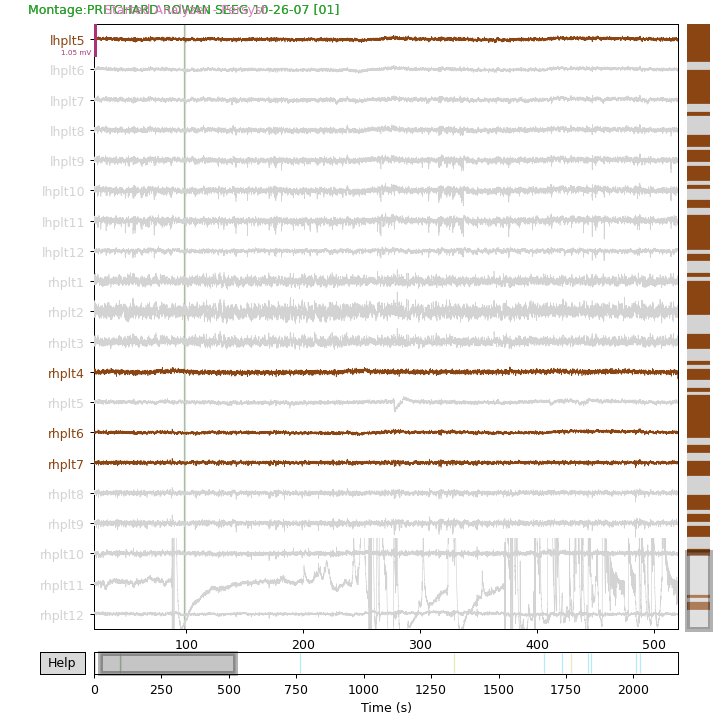

<IPython.core.display.Javascript object>


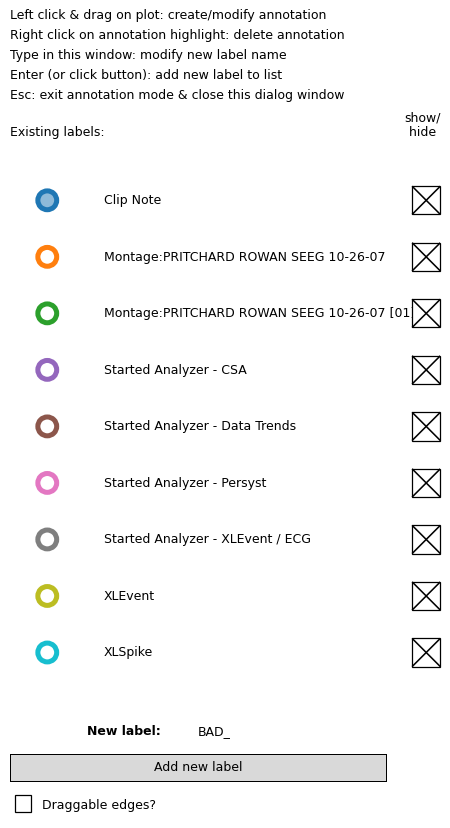

In [38]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=20, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [39]:
mne_data.info['bads']

['lmoif1',
 'lmoif2',
 'rmoif9',
 'lmoif12',
 'lmoif13',
 'rmoif1',
 'rmoif2',
 'rmoif3',
 'rmoif4',
 'rmoif5',
 'lacas10',
 'lacas9',
 'lacas8',
 'lacas1',
 'lacas6',
 'racas1',
 'racas2',
 'racas12',
 'laims1',
 'laims2',
 'laims3',
 'laims5',
 'raims2',
 'raims3',
 'raims4',
 'raims5',
 'raims1',
 'raims14',
 'lsif7',
 'lsif4',
 'lsif5',
 'raims11',
 'raims12',
 'raims10',
 'lpips12',
 'lpips11',
 'lagit1',
 'lagit2',
 'lagit8',
 'lagit9',
 'ragit1',
 'ragit6',
 'lagit10',
 'lagit7',
 'lhplt2',
 'lhplt3',
 'ragit9',
 'lhplt1',
 'lhplt10',
 'lhplt9',
 'lhplt8',
 'lhplt6',
 'lhplt7',
 'rhplt11',
 'lhplt11',
 'lhplt12',
 'rhplt1',
 'rhplt2',
 'rhplt3',
 'rhplt5',
 'rhplt8',
 'rhplt9',
 'rhplt10',
 'rhplt12']

In [40]:
mne_data.info['bads'] = ['lmoif1', 'lmoif2','rmoif9', 'lmoif12', 'lmoif13', 'rmoif1','rmoif2','rmoif3',
                         'rmoif4','rmoif5','lacas10','lacas9','lacas8','lacas1','lacas6','racas1','racas2','racas12',
                         'laims1','laims2','laims3','laims5','raims2','raims3','raims4','raims5','raims1','raims14',
                         'lsif7','lsif4','lsif5','raims11','raims12','raims10','lpips12','lpips11','lagit1','lagit2',
                         'lagit8','lagit9', 'ragit1', 'ragit6', 'lagit10', 'lagit7', 'lhplt2', 'lhplt3', 
                         'ragit9', 'lhplt1', 'lhplt10', 'lhplt9', 'lhplt8','lhplt6', 'lhplt7', 'rhplt11',
                         'lhplt11', 'lhplt12', 'rhplt1', 'rhplt2', 'rhplt3', 'rhplt5', 'rhplt8', 'rhplt9',
                         'rhplt10', 'rhplt12']

In [41]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 64 items (lmoif1, lmoif2, rmoif9, lmoif12, lmoif13, rmoif1, ...)
 ch_names: lloif1, lloif2, lloif3, lloif4, lloif5, lloif6, lloif7, lloif8, ...
 chs: 158 sEEG
 custom_ref_applied: False
 dig: 158 items (158 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 15:59:08 UTC
 nchan: 158
 projs: []
 sfreq: 500.0 Hz
>

# Re-referencing 
- wm reref
- bipolar reref

In [42]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### WM Re-ref

In [43]:
# Re-reference neural data
mne_data_wm_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='wm', 
                                              site='MSSM')

In [44]:
mne_data_wm_reref

<RawEDF | MS002_SWB.edf, 105 x 1083500 (2167.0 s), ~868.1 MB, data loaded>

In [45]:
mne_data_wm_reref.ch_names

['lacas1-lmoif4',
 'lacas10-laims9',
 'lacas2-lmoif4',
 'lacas3-lmoif4',
 'lacas4-lmoif6',
 'lacas5-lmoif6',
 'lacas6-laims9',
 'lacas7-laims9',
 'lacas8-laims9',
 'lacas9-laims9',
 'lagit1-lhplt5',
 'lagit2-lhplt5',
 'lagit3-lhplt5',
 'lagit4-lhplt5',
 'lagit7-lhplt5',
 'lagit8-lhplt5',
 'lagit9-lhplt5',
 'laims1-lloif4',
 'laims11-laims9',
 'laims12-laims9',
 'laims13-laims9',
 'laims2-lloif6',
 'laims3-lloif6',
 'laims4-lloif6',
 'laims5-lsif1',
 'laims6-lsif1',
 'lhplt1-lhplt5',
 'lhplt10-lpips3',
 'lhplt11-lpips3',
 'lhplt12-lpips3',
 'lhplt2-lhplt5',
 'lhplt3-lhplt5',
 'lhplt4-lhplt5',
 'lhplt6-lpips3',
 'lhplt7-lpips3',
 'lhplt8-lpips3',
 'lhplt9-lpips3',
 'lloif1-lmoif6',
 'lloif2-lmoif7',
 'lloif3-lmoif7',
 'lloif7-lloif6',
 'lloif8-lloif6',
 'lloif9-lloif6',
 'lmoif1-lmoif4',
 'lmoif11-lloif6',
 'lmoif12-lloif6',
 'lmoif13-lloif6',
 'lmoif2-lmoif4',
 'lmoif9-lmoif10',
 'lpips1-lpips3',
 'lpips10-lpips8',
 'lpips11-lpips8',
 'lpips12-lpips8',
 'lpips13-lpips9',
 'lpips2-lpips3

In [47]:
mne_data_wm_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)

### Bipolar Re-ref

In [48]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

In [49]:
mne_data_bp_reref

<RawEDF | MS002_SWB.edf, 44 x 1083500 (2167.0 s), ~363.8 MB, data loaded>

In [50]:
mne_data_bp_reref.ch_names

['lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas7',
 'lagit3-lagit4',
 'lagit4-lagit5',
 'laims4-laims6',
 'laims6-laims7',
 'laims10-laims11',
 'laims11-laims12',
 'laims12-laims13',
 'laims13-laims14',
 'lhplt4-lhplt5',
 'lloif1-lloif2',
 'lloif2-lloif3',
 'lloif3-lloif4',
 'lloif6-lloif7',
 'lloif7-lloif8',
 'lloif8-lloif9',
 'lmoif8-lmoif9',
 'lmoif9-lmoif10',
 'lmoif10-lmoif11',
 'lpips1-lpips2',
 'lpips2-lpips3',
 'lpips3-lpips4',
 'lpips4-lpips5',
 'lpips9-lpips10',
 'lpips10-lpips13',
 'lsif3-lsif6',
 'lsif6-lsif8',
 'racas3-racas4',
 'racas6-racas7',
 'racas7-racas8',
 'racas8-racas9',
 'ragit2-ragit3',
 'ragit3-ragit4',
 'ragit5-ragit7',
 'ragit7-ragit8',
 'ragit8-ragit10',
 'raims6-raims7',
 'raims9-raims13',
 'rmoif6-rmoif7',
 'rmoif7-rmoif8',
 'rmoif8-rmoif10']

In [51]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

## Save mne_data

In [52]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [53]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref, mne_data_wm_reref

In [54]:
####add directory for TFRs
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
tfr_dir = f'{base_dir}/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = '01102024' #add date to file name --- update every run!

#load behavior data
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

### Photodiode Alignment

In [56]:
### Photodiode alignment

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.7)

10 blocks
..........

found matches for 105 of 163 pulses


In [58]:
print(slope, offset)

0.9999810029450644 17.498423248413246


## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [62]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [63]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [64]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [65]:
### MAKE SURE CORRECT REREF FILE IS BEING USED!
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
#     ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  98 out of 105 | elapsed:    3.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  98 out of 105 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n

In [66]:
epochs_all_evs 

{'TrialOnset': <Epochs |  148 events (all good), -2 - 1 sec, baseline off, ~178.1 MB, data loaded, with metadata,
  'TrialOnset': 148>,
 'DecisionOnset': <Epochs |  148 events (all good), -1 - 6 sec, baseline off, ~415.3 MB, data loaded, with metadata,
  'DecisionOnset': 148>}

### Add behavioral data to metadata 

In [67]:
behav_df

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0       1       25.0       mix   513.380590   513.390239     515.450091   
1       2      117.0      loss   522.640856   522.641563     524.596127   
2       3       79.0      gain   531.174799   531.175599     532.759061   
3       4       42.0       mix   545.592613   545.593355     548.084966   
4       5       85.0      gain   555.337336   555.345720     557.114656   
..    ...        ...       ...          ...          ...            ...   
144   146      135.0      loss  2082.720686  2082.729062    2087.254288   
145   147        4.0       mix  2094.678701  2094.679411    2096.700082   
146   148      136.0      loss  2107.766044  2107.770228    2110.494307   
147   149       66.0      gain  2117.339199  2117.344685    2118.940681   
148   150       22.0       mix  2126.290743  2126.298584    2128.152942   

     FeedbackOnset        RT  SafeBet  LowBet  ...  totalCPE decisionCPE  \
0       515.457173  2.059852      0.0   -1.10  ...     -0.57       -0.57   
1       526.627092  1.954564     -0.3   -0.95  ...     -0.95       -0.65   
2       534.780269  1.583462      0.4    0.00  ...      1.68        1.28   
3       548.092333  2.491611      0.0   -0.80  ...      0.80        0.80   
4       559.135069  1.768936      0.5    0.00  ...      1.24        0.74   
..             ...       ...      ...     ...  ...       ...         ...   
144    2089.276627  4.525226     -0.5   -1.24  ...      1.24        0.50   
145    2096.707465  2.020671      0.0   -0.30  ...     -0.16       -0.16   
146    2112.504396  2.724080     -0.5   -1.40  ...     -1.40       -0.90   
147    2120.950084  1.595996      0.3    0.00  ...     -0.84       -0.30   
148    2128.160057  1.854358      0.0   -1.10  ...      1.10        1.10   

    totalRegret decisionRegret totalRelief decisionRelief  totalCF  \
0         -0.57          -0.57        0.00           0.00     0.57   
1         -0.95          -0.65        0.00           0.00     0.00   
2          0.00           0.00        1.68           1.28     0.00   
3          0.00           0.00        0.80           0.80    -0.80   
4          0.00           0.00        1.24           0.74     0.00   
..          ...            ...         ...            ...      ...   
144        0.00           0.00        1.24           0.50    -1.24   
145       -0.16          -0.16        0.00           0.00     0.16   
146       -1.40          -0.90        0.00           0.00     0.00   
147       -0.84          -0.30        0.00           0.00     0.84   
148        0.00           0.00        1.10           1.10    -1.10   

     decisionCF  pRPE   nRPE  
0          0.57  0.00  0.000  
1         -0.30  0.00 -0.475  
2          0.40  0.84  0.000  
3         -0.80  0.00  0.000  
4          0.50  0.62  0.000  
..          ...   ...    ...  
144       -0.50  0.62  0.000  
145        0.16  0.00  0.000  
146       -0.50  0.00 -0.700  
147        0.30  0.00 -0.420  
148       -1.10  0.00  0.000  

[148 rows x 32 columns]

In [68]:
behav_params = ['SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
                'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
                'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
                'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE','nRPE']

In [69]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [70]:
epochs_all_evs[event].metadata

lacas1-lmoif4 lacas10-laims9 lacas2-lmoif4 lacas3-lmoif4 lacas4-lmoif6  \
0             NaN            NaN           NaN           NaN           NaN   
1             NaN            NaN           NaN           NaN           NaN   
2             NaN            NaN           NaN           NaN           NaN   
3             NaN            NaN           NaN           NaN           NaN   
4             NaN            NaN           NaN           NaN           NaN   
..            ...            ...           ...           ...           ...   
143           NaN            NaN           NaN           NaN           NaN   
144           NaN            NaN           NaN           NaN           NaN   
145           NaN            NaN           NaN           NaN           NaN   
146           NaN            NaN           NaN           NaN           NaN   
147           NaN            NaN           NaN           NaN           NaN   

    lacas5-lmoif6 lacas6-laims9 lacas7-laims9 lacas8-laims9 lacas9-laims9  \
0             NaN           NaN           NaN           NaN           NaN   
1             NaN           NaN           NaN           NaN           NaN   
2             NaN           NaN           NaN           NaN           NaN   
3             NaN           NaN           NaN           NaN           NaN   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
143           NaN           NaN           NaN           NaN           NaN   
144           NaN           NaN           NaN           NaN           NaN   
145           NaN           NaN           NaN           NaN           NaN   
146           NaN           NaN           NaN           NaN           NaN   
147           NaN           NaN           NaN           NaN           NaN   

     ... totalCPE decisionCPE totalRegret decisionRegret totalRelief  \
0    ...    -0.57       -0.57       -0.57          -0.57        0.00   
1    ...    -0.95       -0.65       -0.95          -0.65        0.00   
2    ...     1.68        1.28        0.00           0.00        1.68   
3    ...     0.80        0.80        0.00           0.00        0.80   
4    ...     1.24        0.74        0.00           0.00        1.24   
..   ...      ...         ...         ...            ...         ...   
143  ...     1.24        0.50        0.00           0.00        1.24   
144  ...    -0.16       -0.16       -0.16          -0.16        0.00   
145  ...    -1.40       -0.90       -1.40          -0.90        0.00   
146  ...    -0.84       -0.30       -0.84          -0.30        0.00   
147  ...     1.10        1.10        0.00           0.00        1.10   

    decisionRelief totalCF decisionCF  pRPE   nRPE  
0             0.00    0.57       0.57  0.00  0.000  
1             0.00    0.00      -0.30  0.00 -0.475  
2             1.28    0.00       0.40  0.84  0.000  
3             0.80   -0.80      -0.80  0.00  0.000  
4             0.74    0.00       0.50  0.62  0.000  
..             ...     ...        ...   ...    ...  
143           0.50   -1.24      -0.50  0.62  0.000  
144           0.00    0.16       0.16  0.00  0.000  
145           0.00    0.00      -0.50  0.00 -0.700  
146           0.00    0.84       0.30  0.00 -0.420  
147           1.10   -1.10      -1.10  0.00  0.000  

[148 rows x 126 columns]

### Save raw epoched data 

In [71]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/wm_epoch_{event}.fif', overwrite=True)
#     epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

### Baseline + Decompose into TFRs

In [72]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [73]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [74]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [76]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


In [77]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 148, channels : 105, ~1.74 GB>}

In [78]:
power_epochs = {}

In [79]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=True, ## make sure this is true!
                                                  baseline_only=False)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



In [80]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 148, channels : 105, ~8.69 GB>

In [81]:
#conda install -c conda-forge h5io must install to save tfr data
# power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/wm_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

<IPython.core.display.Javascript object>


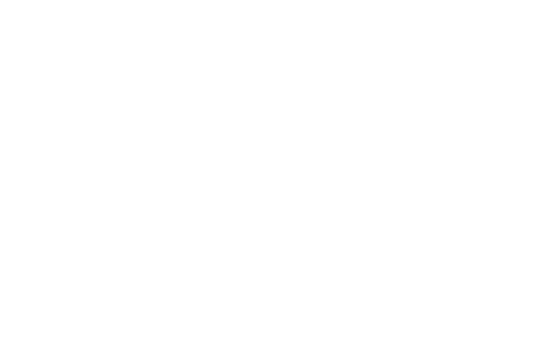

<IPython.core.display.Javascript object>


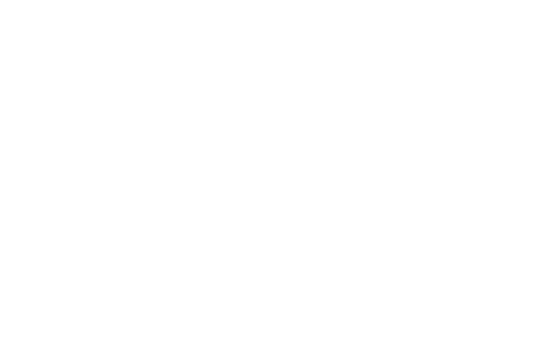

<IPython.core.display.Javascript object>


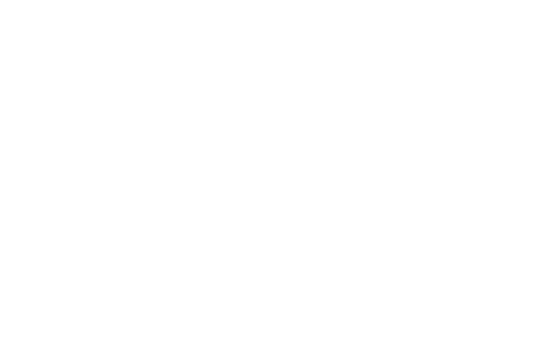

<IPython.core.display.Javascript object>


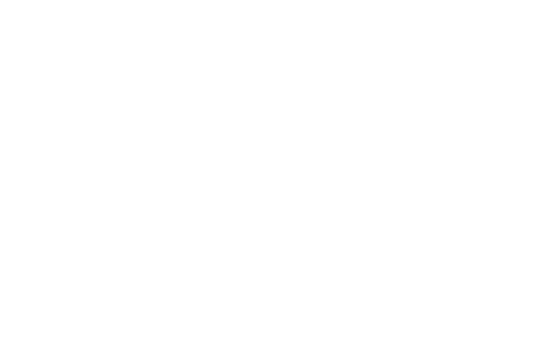

<IPython.core.display.Javascript object>


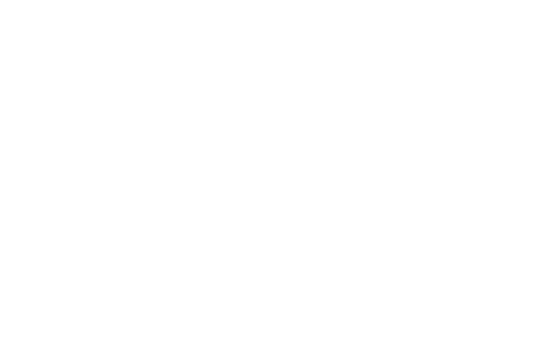

<IPython.core.display.Javascript object>


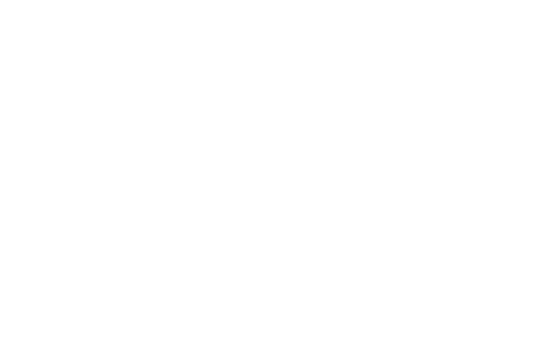

<IPython.core.display.Javascript object>


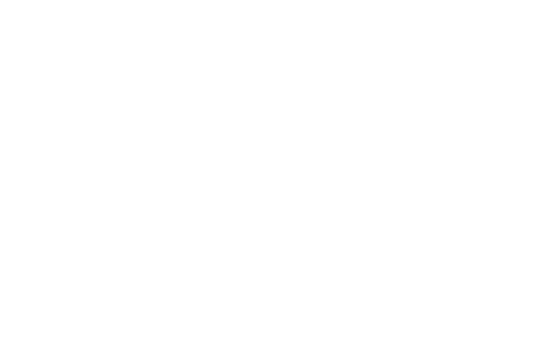

<IPython.core.display.Javascript object>


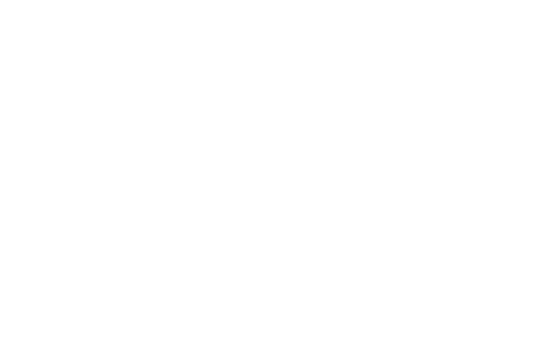

<IPython.core.display.Javascript object>


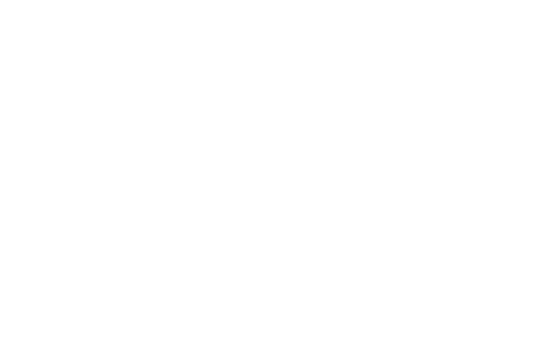

<IPython.core.display.Javascript object>


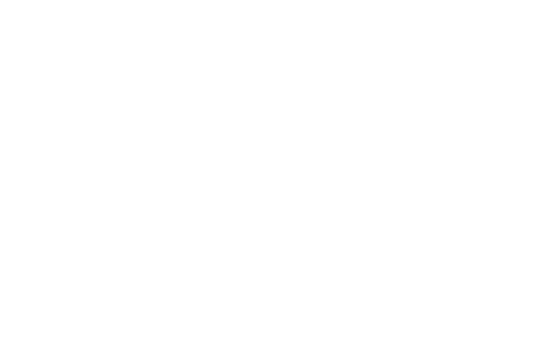

<IPython.core.display.Javascript object>


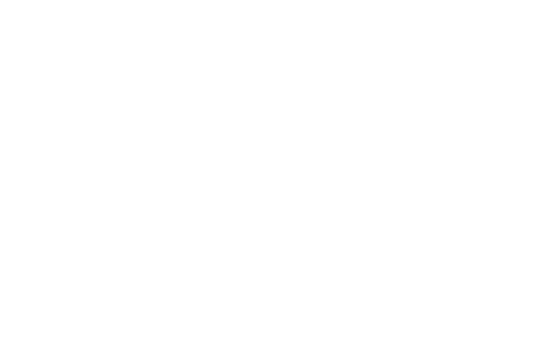

<IPython.core.display.Javascript object>


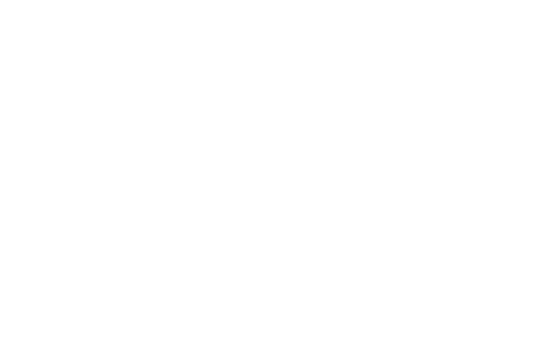

<IPython.core.display.Javascript object>


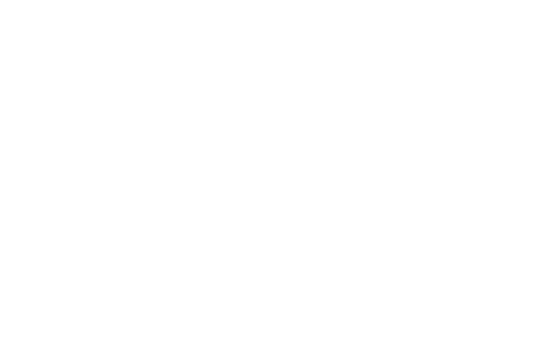

<IPython.core.display.Javascript object>


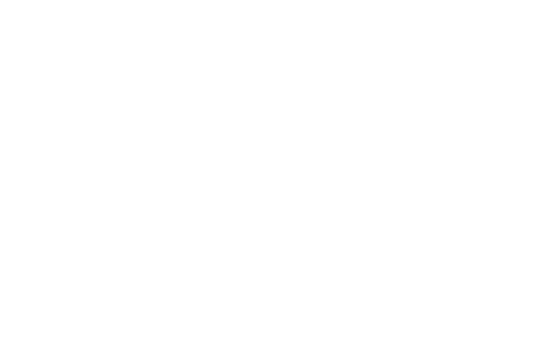

<IPython.core.display.Javascript object>


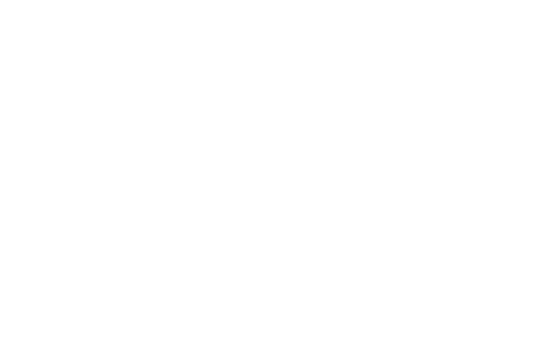

<IPython.core.display.Javascript object>


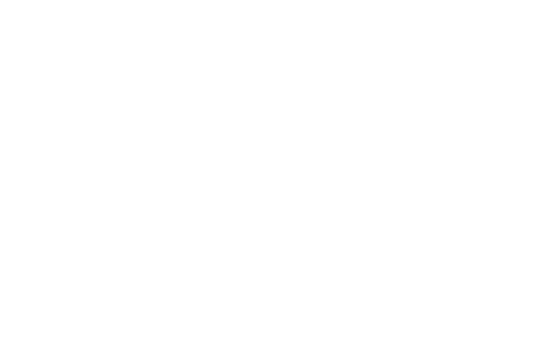

<IPython.core.display.Javascript object>


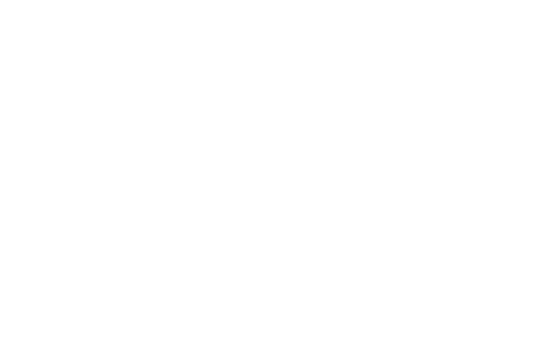

<IPython.core.display.Javascript object>


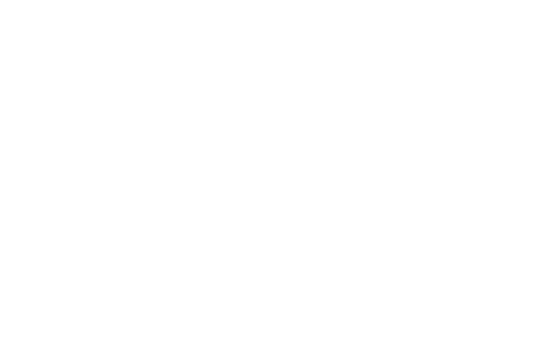

<IPython.core.display.Javascript object>


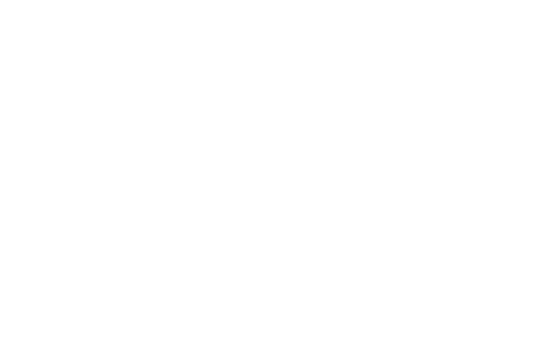

<IPython.core.display.Javascript object>


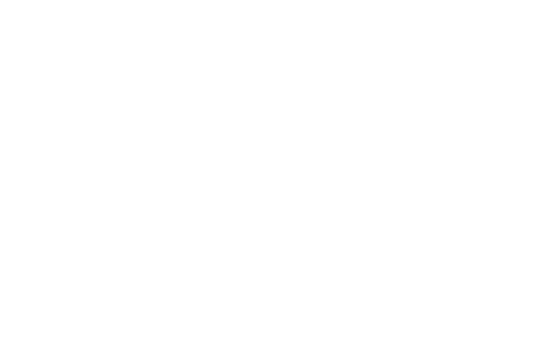

<IPython.core.display.Javascript object>


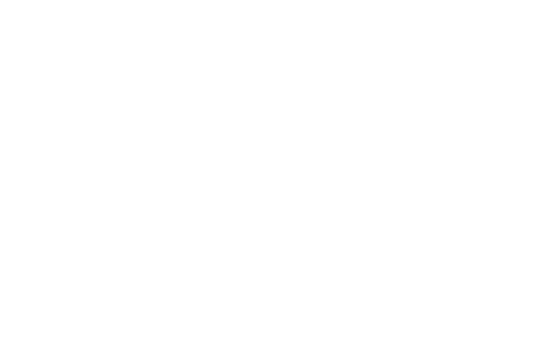

<IPython.core.display.Javascript object>


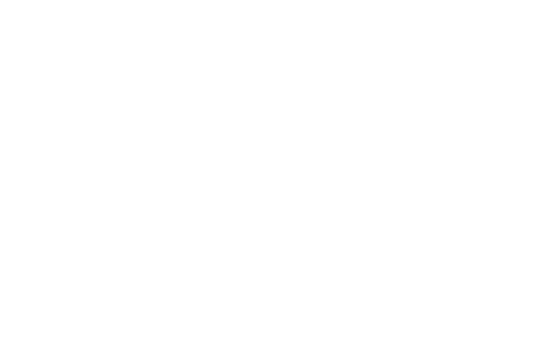

<IPython.core.display.Javascript object>


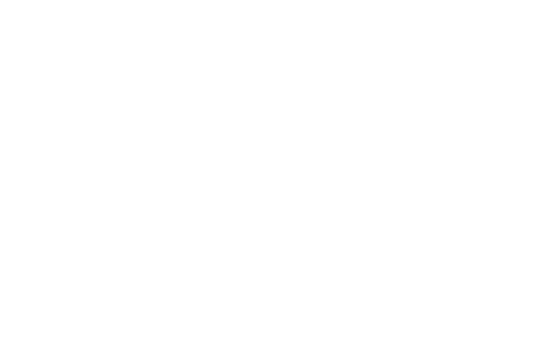

<IPython.core.display.Javascript object>


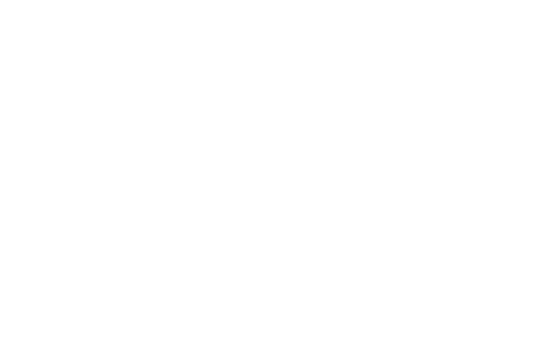

<IPython.core.display.Javascript object>


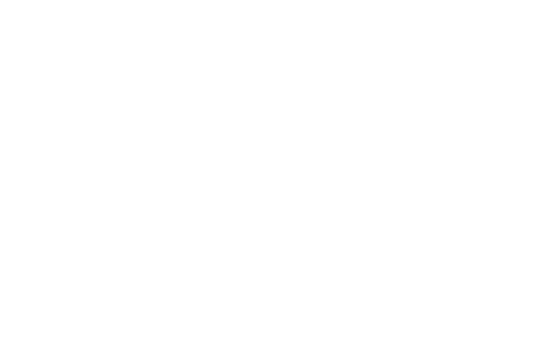

<IPython.core.display.Javascript object>


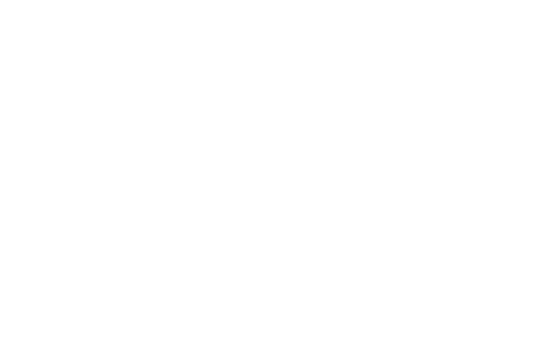

<IPython.core.display.Javascript object>


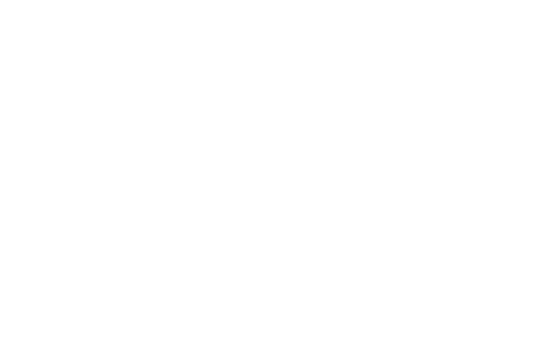

<IPython.core.display.Javascript object>


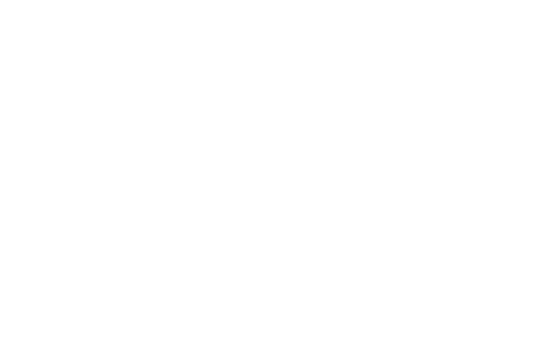

<IPython.core.display.Javascript object>


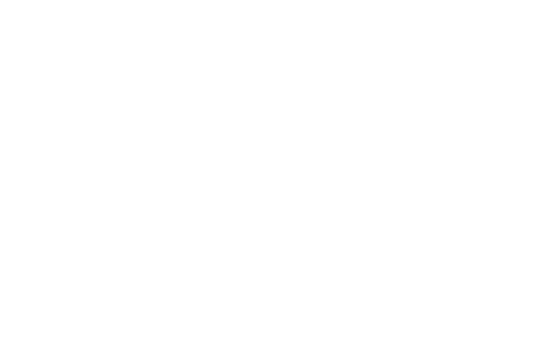

<IPython.core.display.Javascript object>


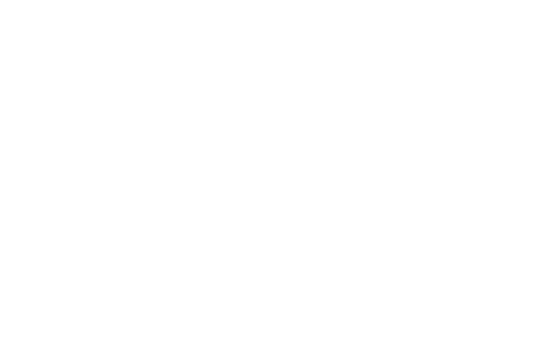

<IPython.core.display.Javascript object>


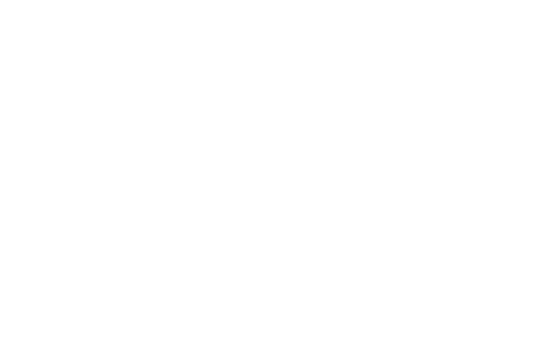

<IPython.core.display.Javascript object>


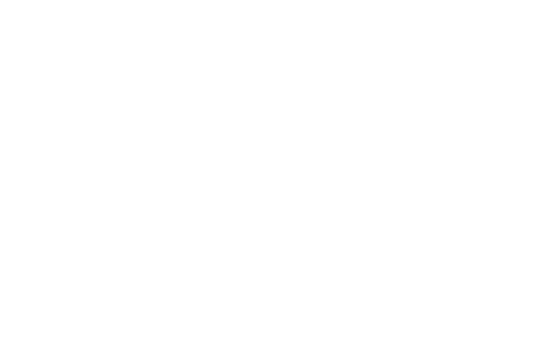

<IPython.core.display.Javascript object>


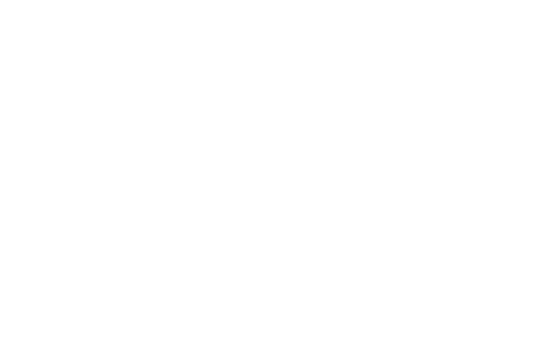

<IPython.core.display.Javascript object>


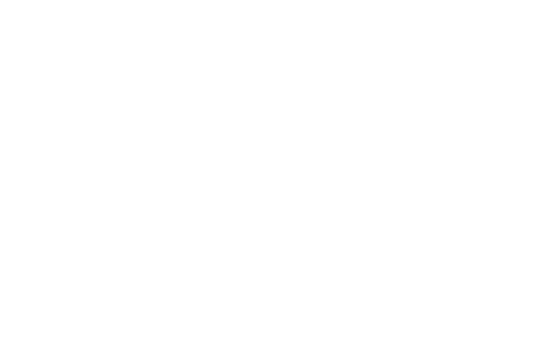

<IPython.core.display.Javascript object>


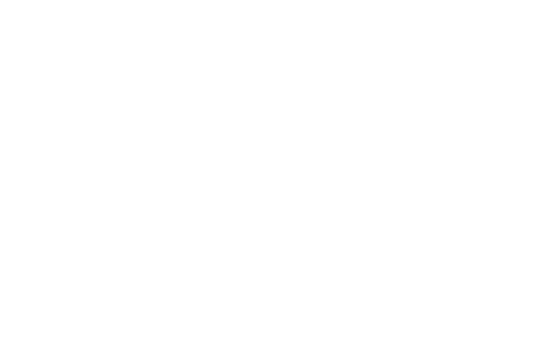

<IPython.core.display.Javascript object>


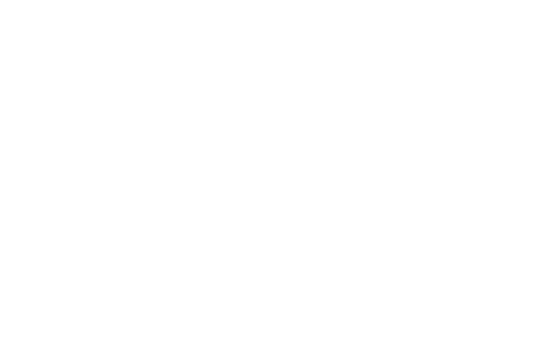

<IPython.core.display.Javascript object>


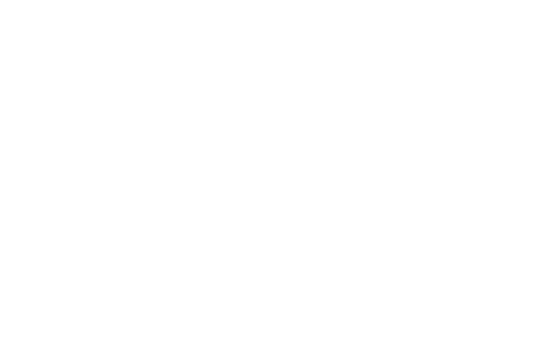

<IPython.core.display.Javascript object>


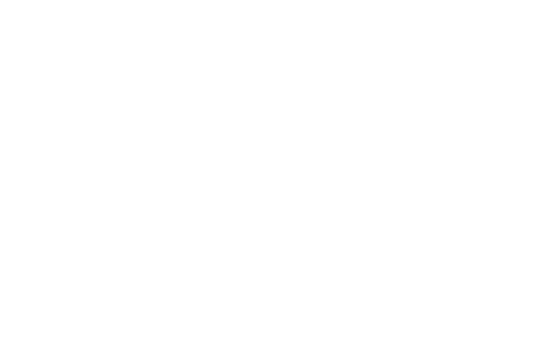

<IPython.core.display.Javascript object>


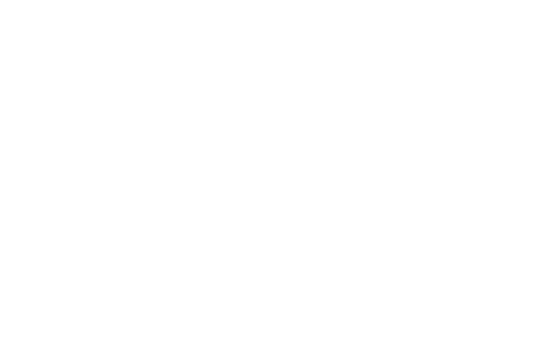

<IPython.core.display.Javascript object>


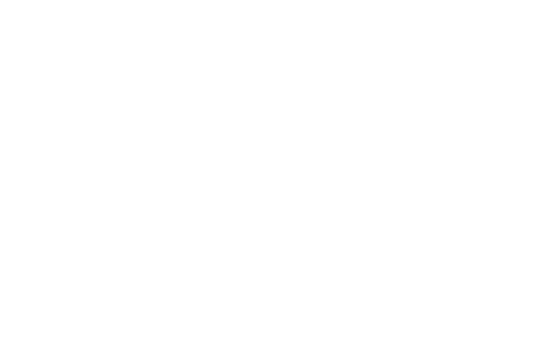

<IPython.core.display.Javascript object>


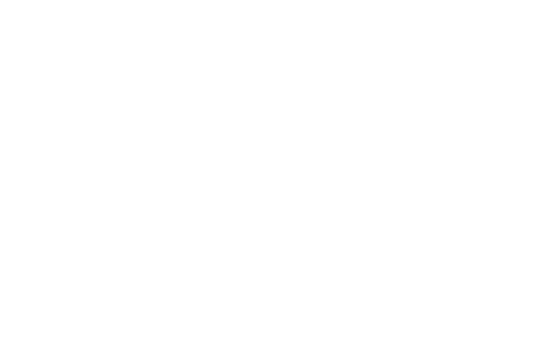

<IPython.core.display.Javascript object>


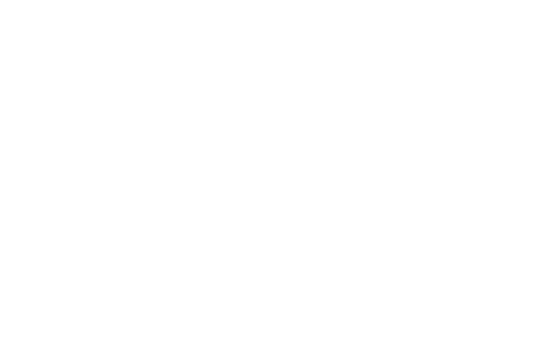

<IPython.core.display.Javascript object>


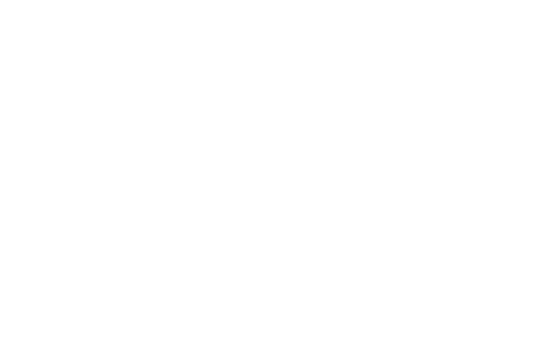

<IPython.core.display.Javascript object>


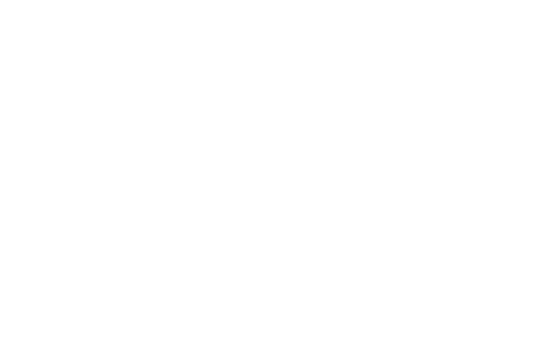

<IPython.core.display.Javascript object>


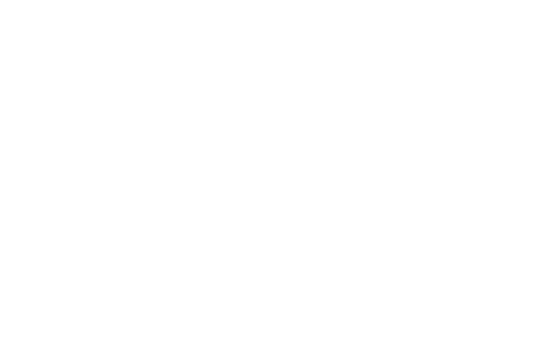

<IPython.core.display.Javascript object>


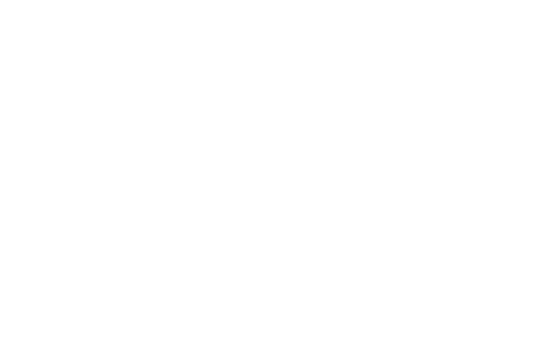

<IPython.core.display.Javascript object>


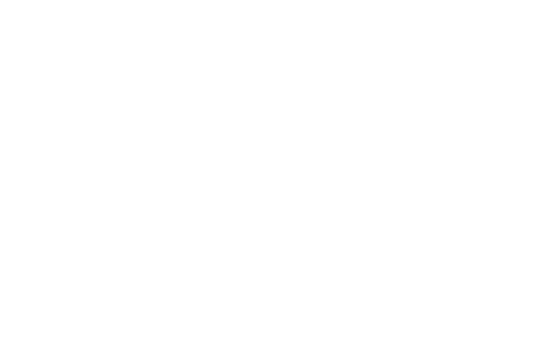

<IPython.core.display.Javascript object>


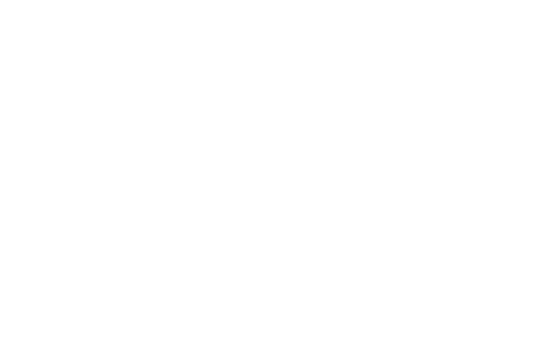

<IPython.core.display.Javascript object>


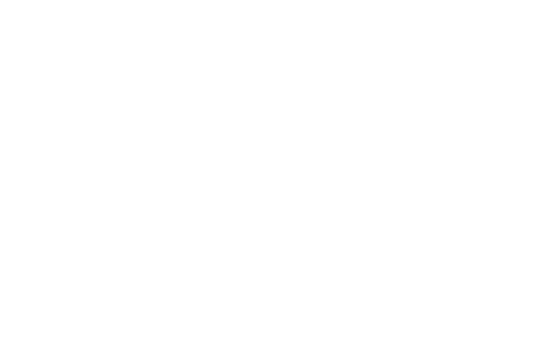

<IPython.core.display.Javascript object>


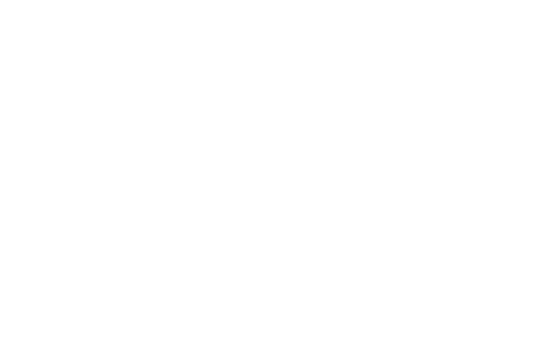

<IPython.core.display.Javascript object>


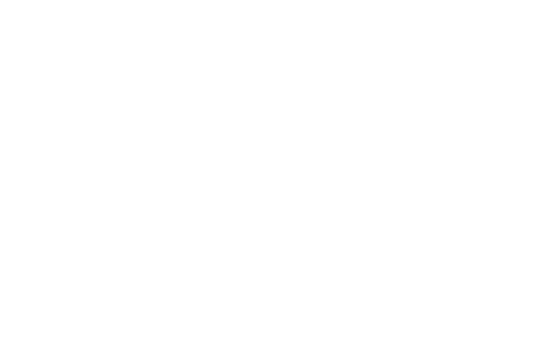

<IPython.core.display.Javascript object>


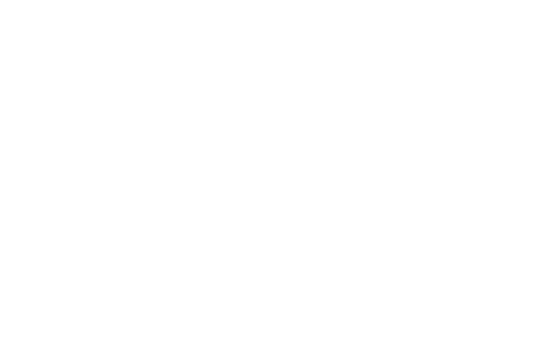

<IPython.core.display.Javascript object>


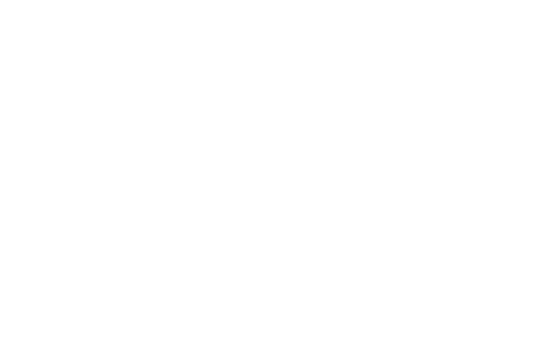

<IPython.core.display.Javascript object>


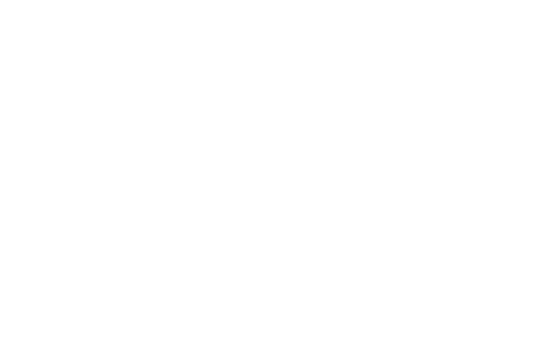

<IPython.core.display.Javascript object>


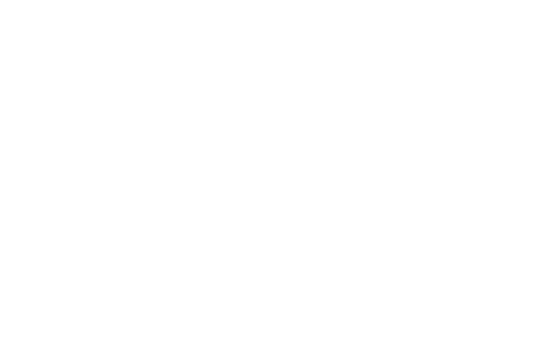

<IPython.core.display.Javascript object>


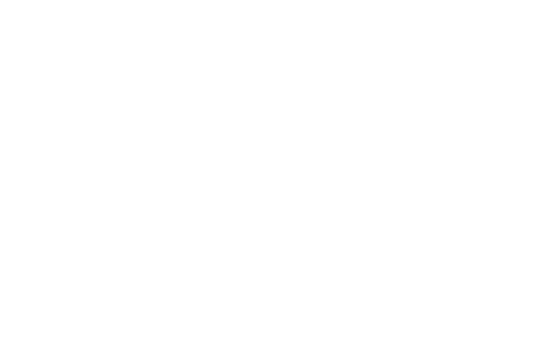

<IPython.core.display.Javascript object>


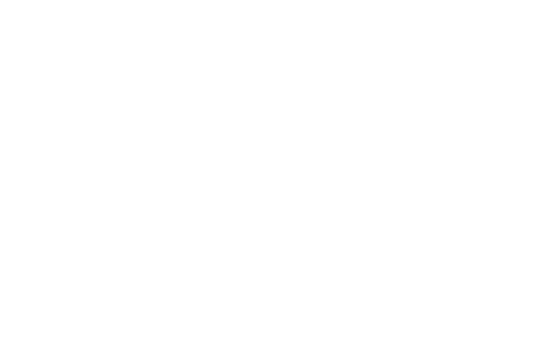

<IPython.core.display.Javascript object>


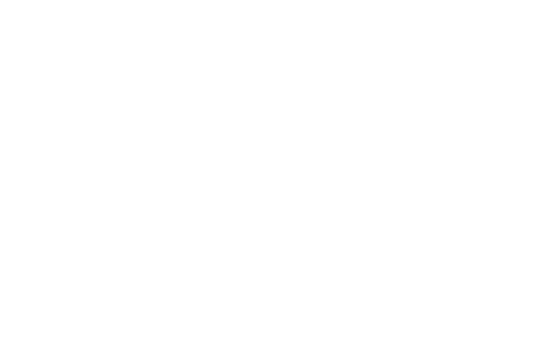

<IPython.core.display.Javascript object>


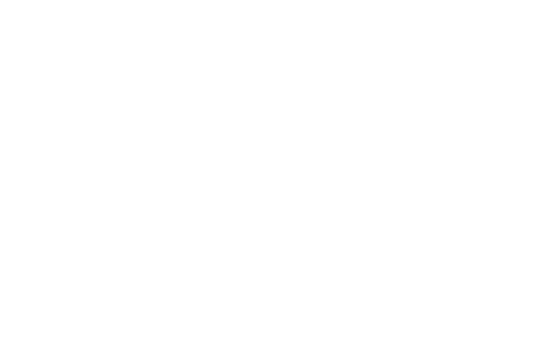

<IPython.core.display.Javascript object>


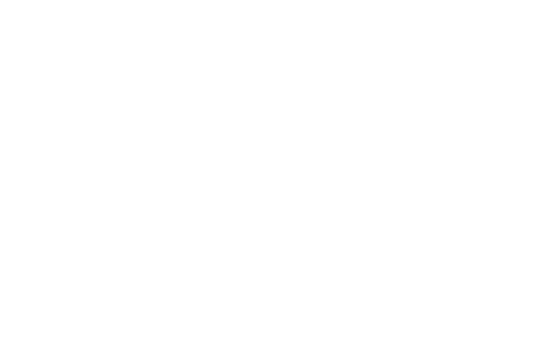

<IPython.core.display.Javascript object>


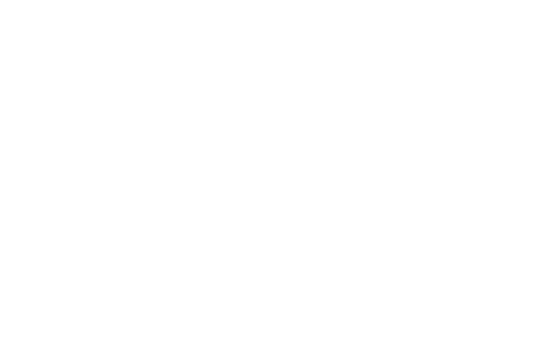

<IPython.core.display.Javascript object>


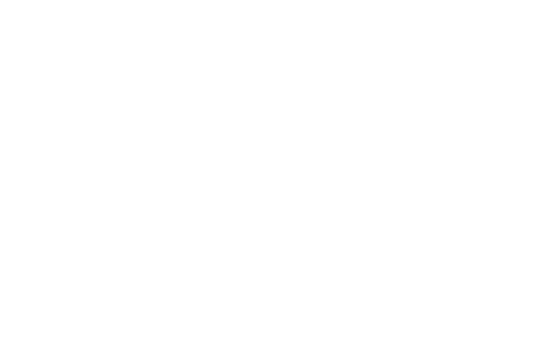

<IPython.core.display.Javascript object>


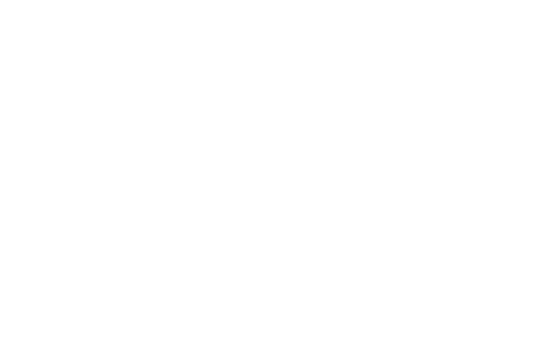

<IPython.core.display.Javascript object>


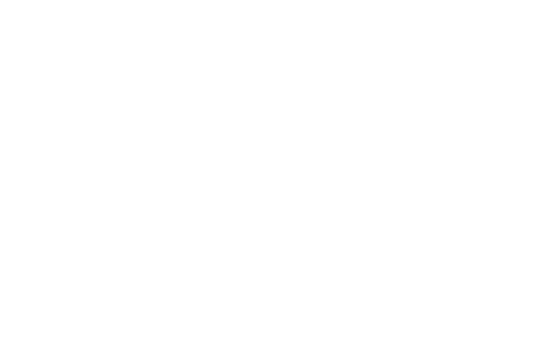

<IPython.core.display.Javascript object>


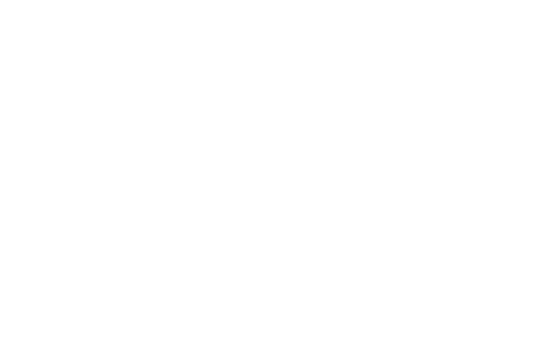

<IPython.core.display.Javascript object>


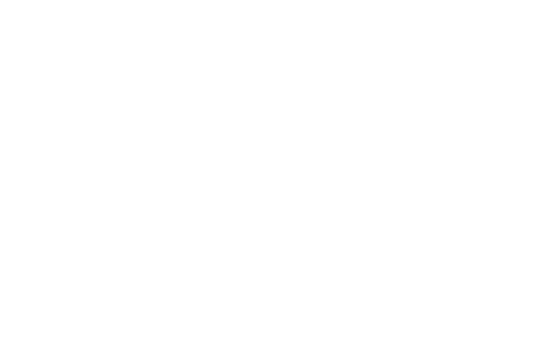

<IPython.core.display.Javascript object>


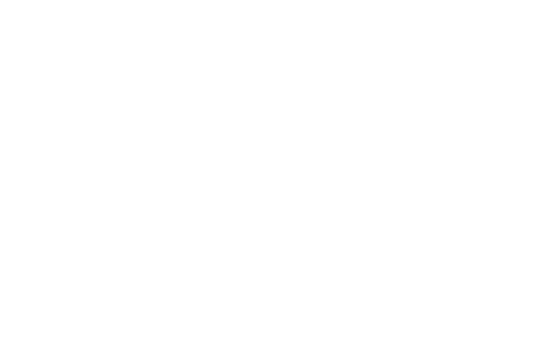

<IPython.core.display.Javascript object>


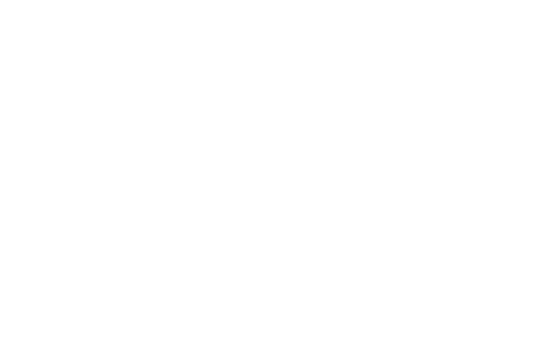

<IPython.core.display.Javascript object>


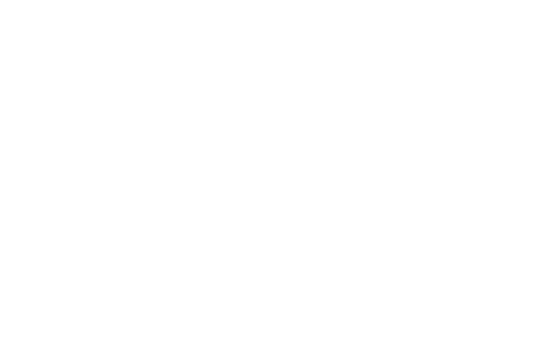

<IPython.core.display.Javascript object>


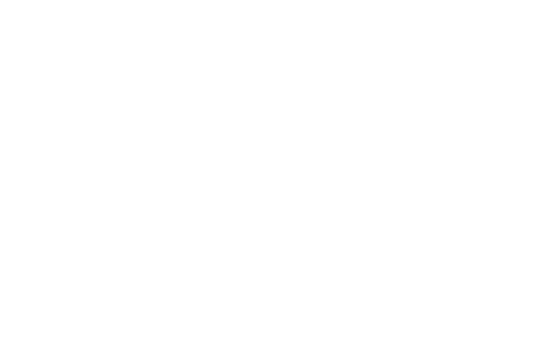

<IPython.core.display.Javascript object>


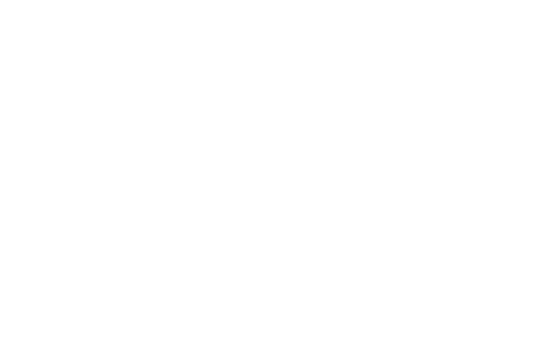

<IPython.core.display.Javascript object>


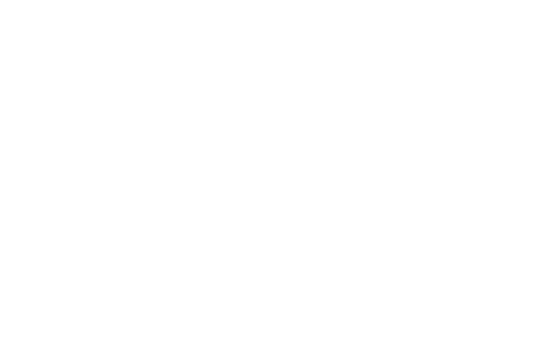

<IPython.core.display.Javascript object>


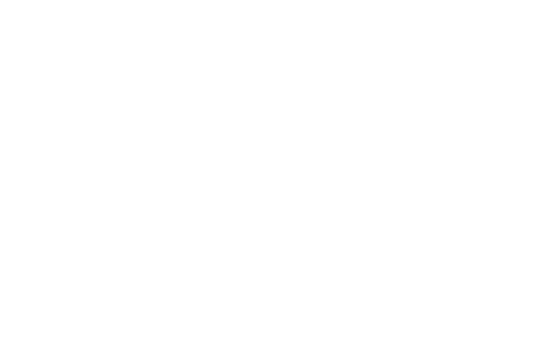

<IPython.core.display.Javascript object>


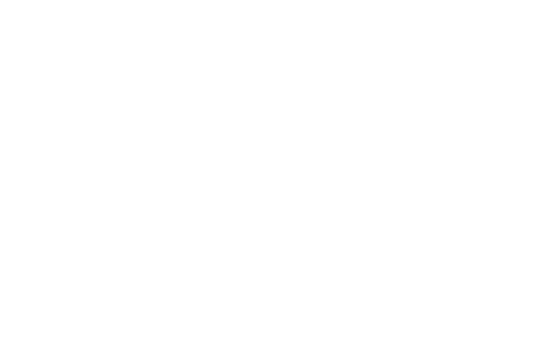

<IPython.core.display.Javascript object>


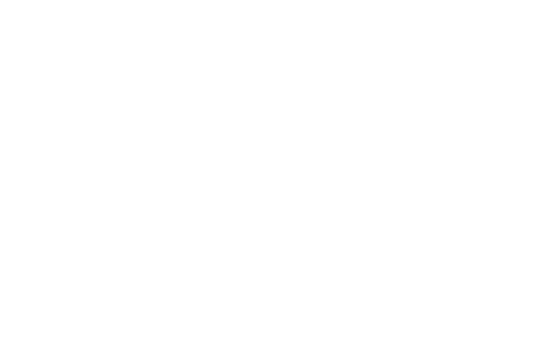

<IPython.core.display.Javascript object>


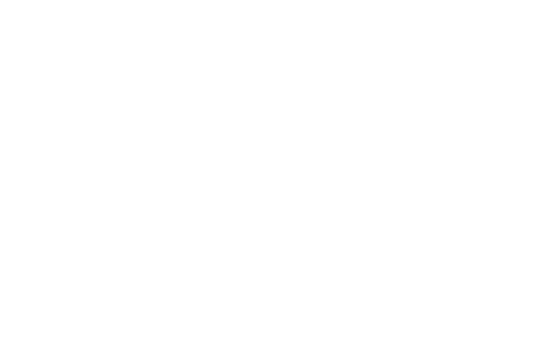

<IPython.core.display.Javascript object>


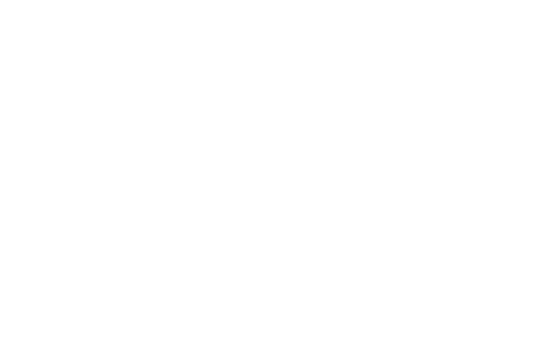

<IPython.core.display.Javascript object>


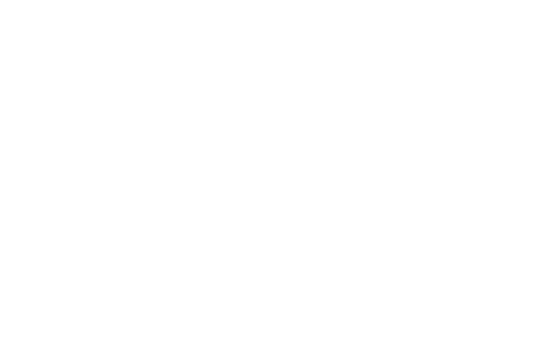

<IPython.core.display.Javascript object>


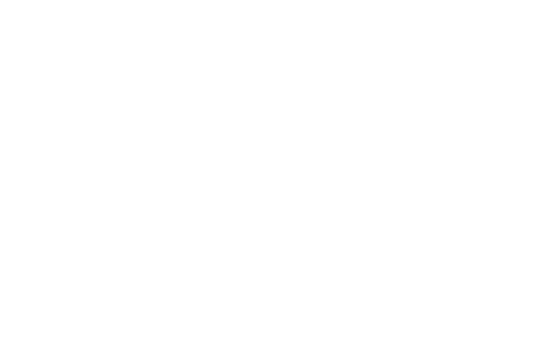

<IPython.core.display.Javascript object>


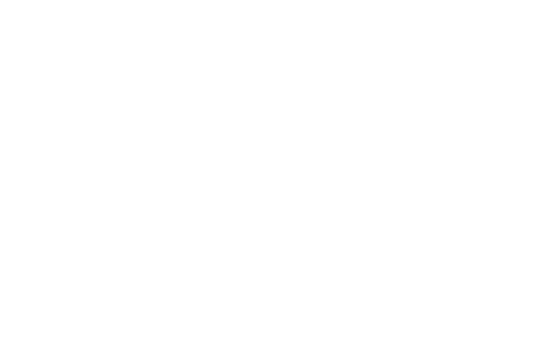

<IPython.core.display.Javascript object>


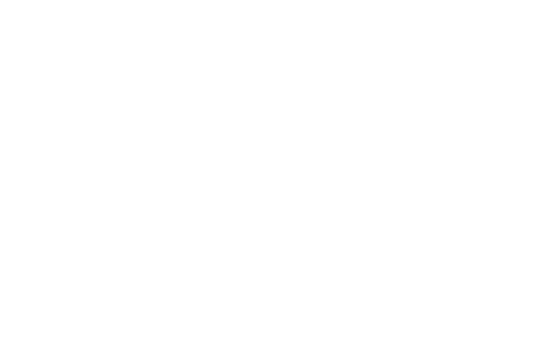

<IPython.core.display.Javascript object>


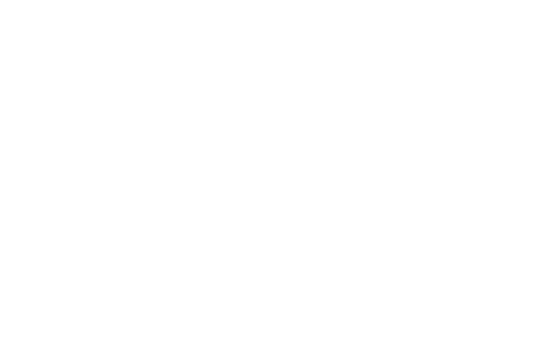

<IPython.core.display.Javascript object>


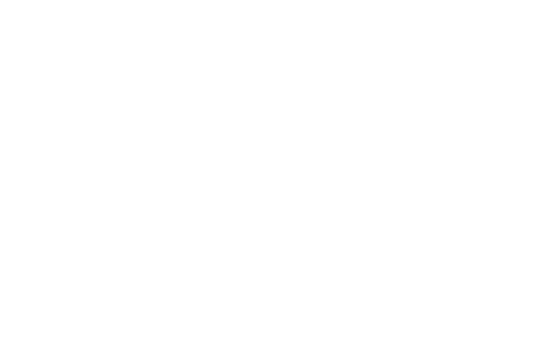

<IPython.core.display.Javascript object>


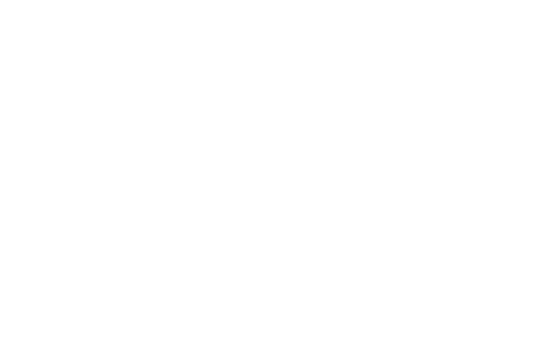

<IPython.core.display.Javascript object>


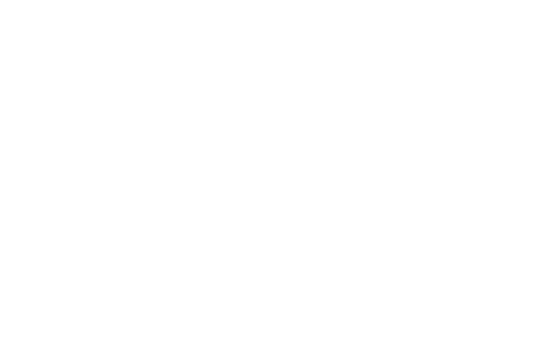

<IPython.core.display.Javascript object>


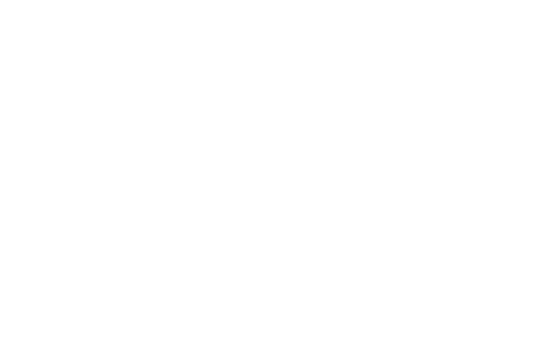

<IPython.core.display.Javascript object>


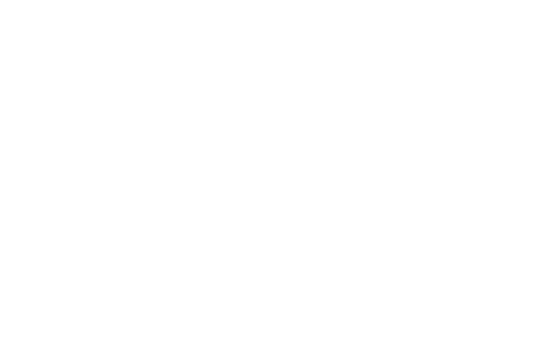

<IPython.core.display.Javascript object>


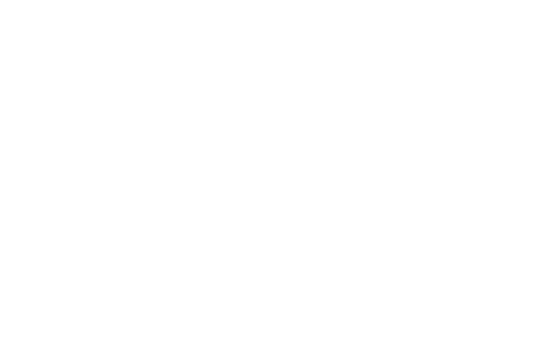

<IPython.core.display.Javascript object>


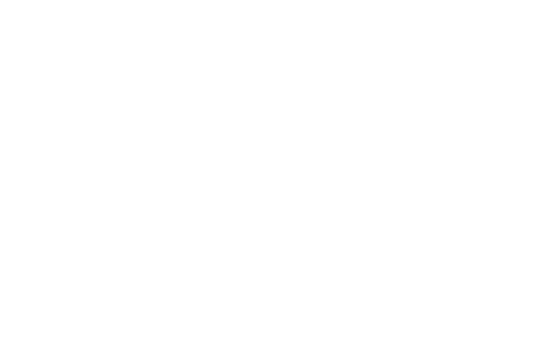

<IPython.core.display.Javascript object>


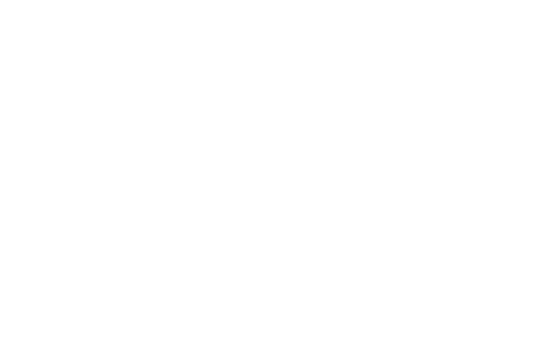

<IPython.core.display.Javascript object>


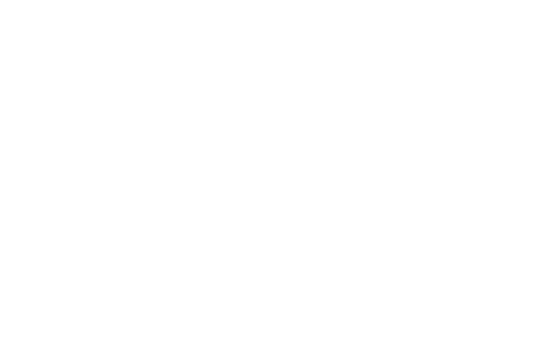

<IPython.core.display.Javascript object>


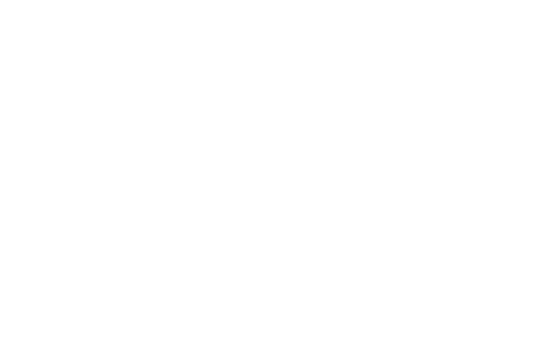

<IPython.core.display.Javascript object>


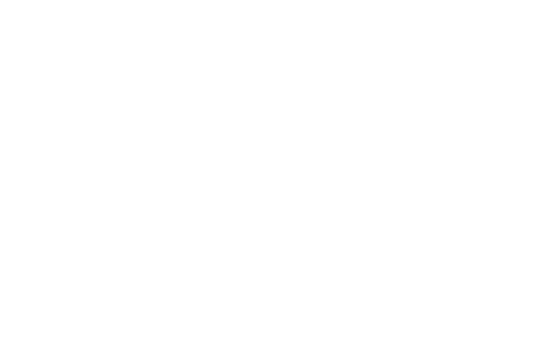

<IPython.core.display.Javascript object>


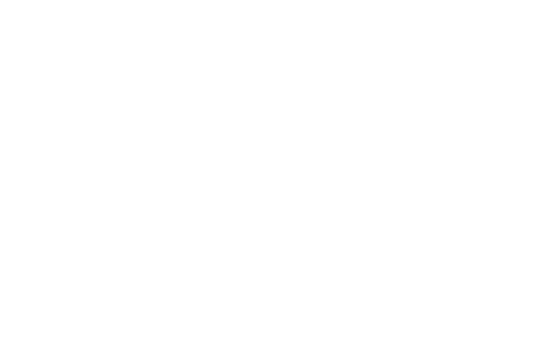

<IPython.core.display.Javascript object>


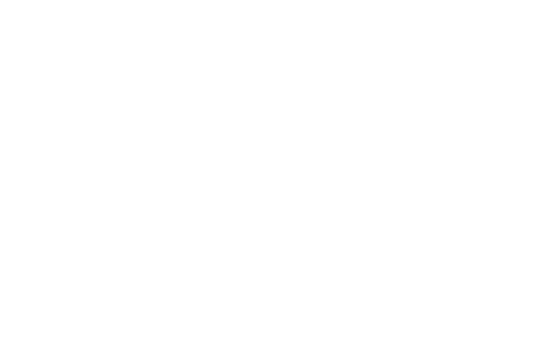

<IPython.core.display.Javascript object>


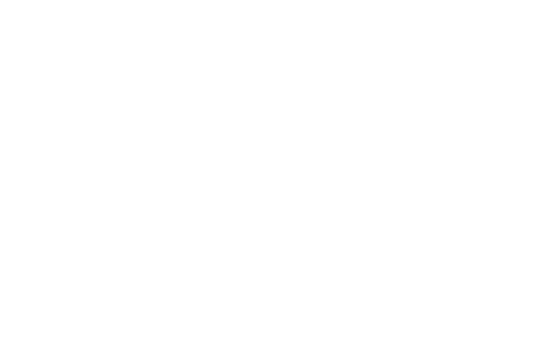

<IPython.core.display.Javascript object>


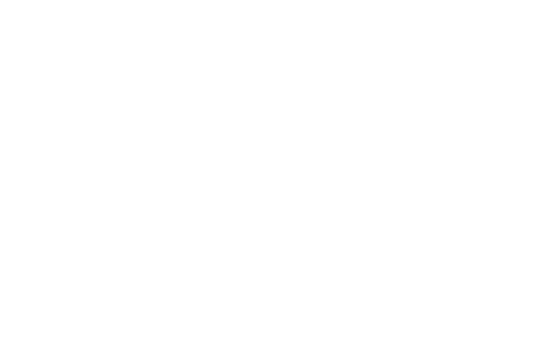

<IPython.core.display.Javascript object>


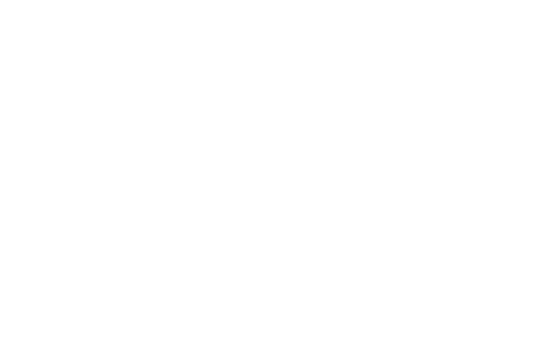

<IPython.core.display.Javascript object>


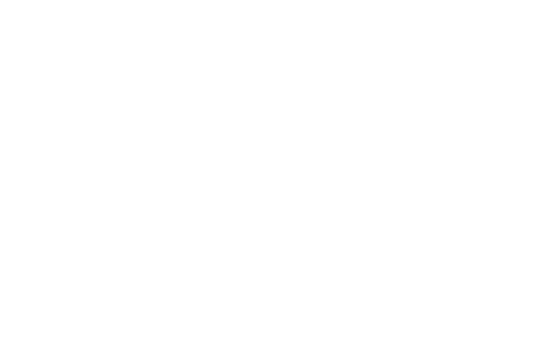

<IPython.core.display.Javascript object>


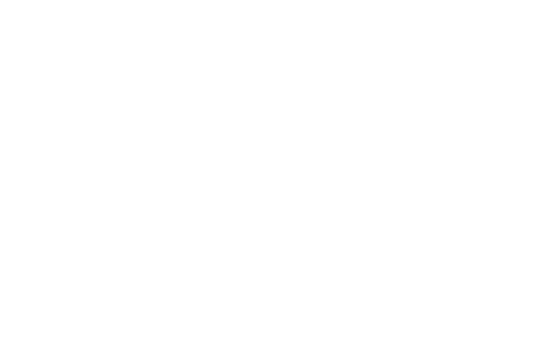

<IPython.core.display.Javascript object>


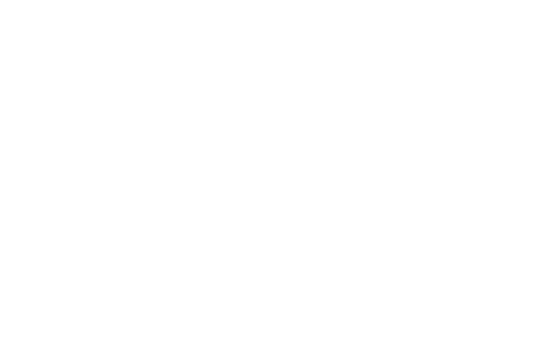

<IPython.core.display.Javascript object>


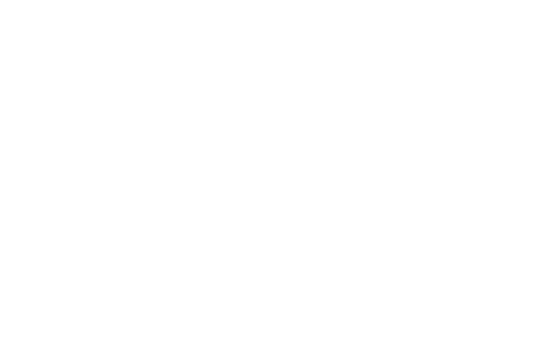

<IPython.core.display.Javascript object>


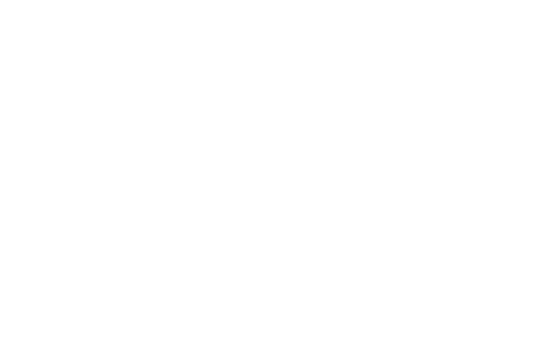

<IPython.core.display.Javascript object>


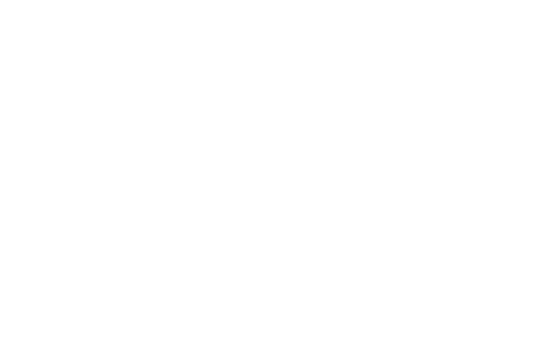

<IPython.core.display.Javascript object>


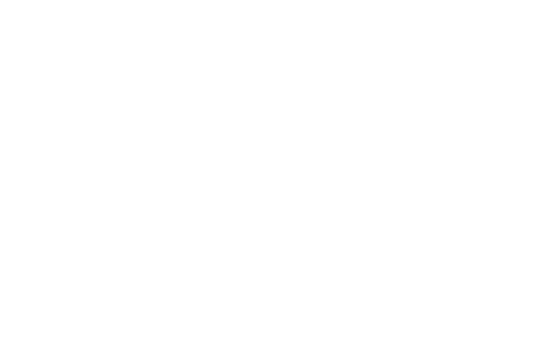

In [82]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir
date = '01102024' #add date to file name 


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_wm_ref.png', format='png', metadata=None,
#     plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()
